In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import pickle
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import emcee
import corner
from lal import C_SI


In [10]:
def dipole_cal(g, ra, dec, l=264, b=48):
    dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    dipole_ICRS = dipole_gal.transform_to('icrs')

    phi_dipole = dipole_ICRS.ra.value*np.pi/180
    theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

    nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
    ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
    nz_dipole = np.cos(theta_dipole)

    phi = ra
    theta = np.pi/2-np.array(dec)

    nx = np.cos(phi)*np.sin(theta)
    ny = np.sin(phi)*np.sin(theta)
    nz = np.cos(theta)

    dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

    return dipole

from scipy.integrate import cumtrapz
from scipy.optimize import fmin
from scipy.interpolate import interp1d, UnivariateSpline

class confidence_interval(object):
    def __init__(self, posterior, param, level=0.683, verbose=False):
        self.posterior = posterior
        self.param = param
        self.level = level
        self.verbose = verbose
        self.lower_level, self.upper_level = self.HDI()
        self.interval = self.upper_level - self.lower_level
        self.map = self.MAP()
        
    def HDI(self):
        cdfvals = cumtrapz(self.posterior, self.param)
        sel = cdfvals > 0.
        x = self.param[1:][sel]
        cdfvals = cdfvals[sel]
        ppf = interp1d(cdfvals, x, fill_value=0., bounds_error=False)

        def intervalWidth(lowTailPr):
            ret = ppf(self.level + lowTailPr) - ppf(lowTailPr)
            if (ret > 0.):
                return ret
            else:
                return 1e4
        HDI_lowTailPr = fmin(intervalWidth, 1. - self.level, disp=self.verbose)[0]
        return ppf(HDI_lowTailPr), ppf(HDI_lowTailPr + self.level)

    def MAP(self):
        sp = UnivariateSpline(self.param, self.posterior, s=0.)
        x_highres = np.linspace(self.param[0], self.param[-1], 100000)
        y_highres = sp(x_highres)
        return x_highres[np.argmax(y_highres)]


In [11]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/BBH/GW_injections_XG.p", "rb")
XG_BBH_inj = pickle.load(fr)
fr.close()

In [12]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/NSBH/GW_injections_XG.p", "rb")
XG_NSBH_inj = pickle.load(fr)
fr.close()

In [13]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/BNS/GW_injections_XG.p", "rb")
XG_BNS_inj = pickle.load(fr)
fr.close()

In [14]:
dl_0_BBH = XG_BBH_inj['injections_parameters']['dls']
dl_0_NSBH = XG_NSBH_inj['injections_parameters']['dls']
dl_0_BNS = XG_BNS_inj['injections_parameters']['dls']

In [15]:
index_BBH = []
index_NSBH = []
index_BNS = []

for i in range(len(dl_0_BBH)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0005/BBH_cov_{i}.txt')
        if len(XG_BBH_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_BBH[i]<461:
            index_BBH.append(i)
    except:
        continue

for i in range(len(dl_0_NSBH)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0005/NSBH_cov_{i}.txt')
        if len(XG_NSBH_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_NSBH[i]<461:
            index_NSBH.append(i)
    except:
        continue

for i in range(len(dl_0_BNS)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0005/BNS_cov_{i}.txt')
        if len(XG_BNS_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_BNS[i]<461:
            index_BNS.append(i)
    except:
        continue


In [16]:
len(index_BBH),len(index_NSBH),len(index_BNS)

(33, 3, 3)

In [17]:
index_BBH

[1,
 2,
 3,
 7,
 8,
 9,
 14,
 15,
 16,
 17,
 18,
 21,
 22,
 24,
 27,
 28,
 29,
 30,
 32,
 33,
 36,
 37,
 39,
 42,
 43,
 44,
 46,
 48,
 50,
 51,
 53,
 54,
 57]

In [18]:
index_NSBH

[6, 23, 39]

In [19]:
index_BNS

[1, 40, 44]

In [20]:
# samples = [0]*(len(index_BBH)+len(index_NSBH)+len(index_BNS))
# for i,ind in enumerate(index_BBH):
#     samples[i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p0005/BBH_Fisher_samples_{ind}.dat', names=True)
# for i,ind in enumerate(index_NSBH):
#     samples[len(index_BBH)+i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p0005/NSBH_Fisher_samples_{ind}.dat', names=True)
# for i,ind in enumerate(index_BNS):
#     samples[len(index_BBH)+len(index_NSBH)+i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p0005/BNS_Fisher_samples_{ind}.dat', names=True)


In [21]:
index_all = np.append(np.append(np.array(index_BBH),np.array(index_NSBH)),np.array(index_BNS))

In [22]:
# fig = plt.figure(figsize=(26,25))
# gs = gridspec.GridSpec(10, 8, wspace=0.1)

# for i in range(0,10):
#     for j in range(0,8):

#         if 8*i+j >= len(index_BBH)+len(index_NSBH)+len(index_BNS):
#             break

#         ax = plt.subplot(gs[8*i+j])
#         plt.title('event %d'%index_all[8*i+j])

#         plt.hist(samples[8*i+j]['ra']/np.pi*180,bins=50,histtype='step')

#         plt.axvline(np.mean(samples[8*i+j]['ra']/np.pi*180),color='k',linestyle='--',alpha=0.6)

#         if j==0:
#             ax.set_ylabel('likelihood',fontsize=15)

#         ax.set_yticklabels([])
#         # plt.xlim(10,200)
#         plt.ylim(bottom=0)

In [23]:
# fig = plt.figure(figsize=(26,25))
# gs = gridspec.GridSpec(10, 8, wspace=0.1)

# for i in range(0,10):
#     for j in range(0,8):

#         if 8*i+j >= len(index_BBH)+len(index_NSBH)+len(index_BNS):
#             break

#         ax = plt.subplot(gs[8*i+j])
#         plt.title('event %d'%index_all[8*i+j])

#         plt.hist(samples[8*i+j]['dec']/np.pi*180,bins=50,histtype='step')

#         plt.axvline(np.mean(samples[8*i+j]['dec']/np.pi*180),color='k',linestyle='--',alpha=0.6)

#         if j==0:
#             ax.set_ylabel('likelihood',fontsize=15)

#         ax.set_yticklabels([])
#         # plt.xlim(10,200)
#         plt.ylim(bottom=0)

In [24]:
# ra_std = [0]*len(index_all)
# dec_std = [0]*len(index_all)
# ra_mean = [0]*len(index_all)
# dec_mean = [0]*len(index_all)
# for i in range(len(index_all)):
#     ra_std[i] = np.std(samples[i]['ra'])
#     dec_std[i] = np.std(samples[i]['dec'])
#     ra_mean[i] = np.mean(samples[i]['ra'])
#     dec_mean[i] = np.mean(samples[i]['dec'])

In [25]:
zs = [0]*len(index_all)
ra_mean = [0]*len(index_all)
dec_mean = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    zs[i] = XG_BBH_inj['injections_parameters']['zs'][ind]
    ra_mean[i] = XG_BBH_inj['injections_parameters']['ras'][ind]
    dec_mean[i] = XG_BBH_inj['injections_parameters']['decs'][ind]
for i,ind in enumerate(index_NSBH):
    zs[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['zs'][ind]
    ra_mean[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['ras'][ind]
    dec_mean[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['decs'][ind]
for i,ind in enumerate(index_BNS):
    zs[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['zs'][ind]
    ra_mean[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['ras'][ind]
    dec_mean[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['decs'][ind]

In [26]:
g=0.0005

z0 = [0]*len(index_all)
for i,ind in enumerate(index_BBH):
    z0[i] = (1+zs[i]) * (1+dipole_cal(g, XG_BBH_inj['injections_parameters']['ras'][ind], XG_BBH_inj['injections_parameters']['decs'][ind])) -1
for i,ind in enumerate(index_NSBH):
    z0[len(index_BBH)+i] = (1+zs[len(index_BBH)+i]) * (1+dipole_cal(g, XG_NSBH_inj['injections_parameters']['ras'][ind], XG_NSBH_inj['injections_parameters']['decs'][ind])) -1
for i,ind in enumerate(index_BNS):
    z0[len(index_BBH)+len(index_NSBH)+i] = (1+zs[len(index_BBH)+len(index_NSBH)+i]) * (1+dipole_cal(g, XG_BNS_inj['injections_parameters']['ras'][ind], XG_BNS_inj['injections_parameters']['decs'][ind])) -1

In [27]:
ra_std = [0]*len(index_all)
dec_std = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0005/BBH_cov_{ind}.txt')
    ra_std[i] = np.sqrt(data[4,4])
    dec_std[i] = np.sqrt(data[5,5])
for i,ind in enumerate(index_NSBH):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0005/NSBH_cov_{ind}.txt')
    ra_std[len(index_BBH)+i] = np.sqrt(data[4,4])
    dec_std[len(index_BBH)+i] = np.sqrt(data[5,5])
for i,ind in enumerate(index_BNS):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0005/BNS_cov_{ind}.txt')
    ra_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[4,4])
    dec_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[5,5])    

In [28]:
np.array(ra_std)/np.pi*180

array([0.04302289, 0.01979619, 0.09816881, 0.0124387 , 0.02242399,
       0.03519319, 0.01941064, 0.02037531, 0.02874846, 0.03172333,
       0.01937035, 0.03415812, 0.04337306, 0.05135853, 0.04771032,
       0.09905177, 0.03154377, 0.06633643, 0.01869119, 0.0180463 ,
       0.01221112, 0.01649359, 0.03244442, 0.01430973, 0.03278627,
       0.07826275, 0.02244436, 0.05028223, 0.00476039, 0.04041326,
       0.03884363, 0.02889656, 0.06156004, 0.03827273, 0.05353495,
       0.06880577, 0.07052194, 0.01927284, 0.08483105])

In [29]:
np.array(dec_std)/np.pi*180

array([0.00736208, 0.14857152, 0.03331888, 0.0426113 , 0.02044569,
       0.01190478, 0.02538993, 0.01452779, 0.02811249, 0.00641104,
       0.01991146, 0.05563835, 0.076155  , 0.04158078, 0.04860694,
       0.0189135 , 0.02253563, 0.01902275, 0.01869467, 0.0380918 ,
       0.15781117, 0.02996021, 0.03403238, 0.02045367, 0.03566877,
       0.01774815, 0.01180146, 0.06341906, 0.00407283, 0.01145641,
       0.02670967, 0.00698771, 0.01511612, 0.04655766, 0.04099211,
       0.04208062, 0.05065611, 0.09891926, 0.03487376])

In [30]:
4*np.array(ra_std)/np.pi*180*np.array(dec_std)/np.pi*180

array([1.26695115e-03, 1.17645998e-02, 1.30835004e-02, 2.12011727e-03,
       1.83389625e-03, 1.67586849e-03, 1.97133955e-03, 1.18403318e-03,
       3.23276326e-03, 8.13518294e-04, 1.54276800e-03, 7.60200667e-03,
       1.32123027e-02, 8.54211190e-03, 9.27621016e-03, 7.49366313e-03,
       2.84343517e-03, 5.04760565e-03, 1.39770299e-03, 2.74966414e-03,
       7.70820589e-03, 1.97660507e-03, 4.41664300e-03, 1.17074590e-03,
       4.67778427e-03, 5.55607471e-03, 1.05950444e-03, 1.27554064e-02,
       7.75529632e-05, 1.85196376e-03, 4.15000299e-03, 8.07683316e-04,
       3.72219593e-03, 7.12755375e-03, 8.77804090e-03, 1.15815579e-02,
       1.42894678e-02, 7.62581949e-03, 1.18335123e-02])

In [31]:
dl_mean = [0]*len(index_all)
dl_std = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    dl_mean[i] = dl_0_BBH[ind] * (1+dipole_cal(g, XG_BBH_inj['injections_parameters']['ras'][ind], XG_BBH_inj['injections_parameters']['decs'][ind]))
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0005/BBH_cov_{ind}.txt')
    dl_std[i] = np.sqrt(data[2,2])
for i,ind in enumerate(index_NSBH):
    dl_mean[len(index_BBH)+i] = dl_0_NSBH[ind] * (1+dipole_cal(g, XG_NSBH_inj['injections_parameters']['ras'][ind], XG_NSBH_inj['injections_parameters']['decs'][ind]))
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0005/NSBH_cov_{ind}.txt')
    dl_std[len(index_BBH)+i] = np.sqrt(data[2,2])
for i,ind in enumerate(index_BNS):
    dl_mean[len(index_BBH)+len(index_NSBH)+i] = dl_0_BNS[ind] * (1+dipole_cal(g, XG_BNS_inj['injections_parameters']['ras'][ind], XG_BNS_inj['injections_parameters']['decs'][ind])) 
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p0005/BNS_cov_{ind}.txt')
    dl_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[2,2])
 
    # dl_mean[i] = np.mean(samples[i]['luminosity_distance'])
    # dl_std[i] = np.std(samples[i]['luminosity_distance'])

In [42]:
dl_mean[40]

398.68865870813386

In [32]:
def chi2_dl_dipole(glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, H0=70, Om0=0.3):
    g = glb[0]
    l = glb[1]
    b = glb[2]
    
    dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    dipole_ICRS = dipole_gal.transform_to('icrs')

    phi_dipole = dipole_ICRS.ra.value*np.pi/180
    theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

    nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
    ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
    nz_dipole = np.cos(theta_dipole)

    chi2 = 0

    for i in range(len(ra_arr)):
        phi = ra_arr[i]
        theta = np.pi/2-np.array(dec_arr[i])

        nx = np.cos(phi)*np.sin(theta)
        ny = np.sin(phi)*np.sin(theta)
        nz = np.cos(theta)

        dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

        astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
        zt = (1+zs_arr[i])/(1+dipole) -1
        dl_0 = astropy_cosmology.luminosity_distance(zt).value
        dl_g = dl_0*(1+dipole)

        chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2

    return chi2


In [33]:
chi2_dl_dipole([1.250e-04, 268, 48], ra_mean, dec_mean, z0, dl_mean, dl_std, H0=70, Om0=0.3)

99.16877313722398

In [34]:
minimize(chi2_dl_dipole, [0,268,48], args=(ra_mean, dec_mean, z0, dl_mean, dl_std), method='Nelder-Mead')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.3215463278897058e-11
             x: [ 5.000e-04  2.640e+02  4.800e+01]
           nit: 83
          nfev: 152
 final_simplex: (array([[ 5.000e-04,  2.640e+02,  4.800e+01],
                       [ 5.000e-04,  2.640e+02,  4.800e+01],
                       [ 5.000e-04,  2.640e+02,  4.800e+01],
                       [ 5.000e-04,  2.640e+02,  4.800e+01]]), array([ 1.322e-11,  9.081e-11,  9.283e-11,  1.349e-10]))

In [35]:
# cov_index = [0]*len(index)
# for i,ind in enumerate(index):
#     cov_data = np.loadtxt(f'covariance_XG_snr500/cov_{ind}.txt')
#     cov_index[i] = np.zeros((3,3))
#     cov_index[i][0,0] = cov_data[2,2]
#     cov_index[i][0,1:] = cov_data[2,4:]
#     cov_index[i][1:,0] = cov_data[4:,2]
#     cov_index[i][1:,1:] = cov_data[4:,4:]

In [43]:
def logprob_dl_g(glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, H0=70, Om0=0.3):
    g = glb[0]
    l = glb[1]
    b = glb[2]

    if 0<=g<1 and 0<=l<360 and -90<=b<=90:

        dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
        dipole_ICRS = dipole_gal.transform_to('icrs')

        phi_dipole = dipole_ICRS.ra.value*np.pi/180
        theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

        nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
        ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
        nz_dipole = np.cos(theta_dipole)

        chi2 = 0

        for i in range(len(ra_arr)):
            phi = ra_arr[i]
            theta = np.pi/2-np.array(dec_arr[i])

            nx = np.cos(phi)*np.sin(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(theta)

            dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

            astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
            zt = (1+zs_arr[i])/(1+dipole) -1
            dl_0 = astropy_cosmology.luminosity_distance(zt).value
            dl_g = dl_0*(1+dipole)

            # x = np.array([dl_g, ra_arr[i], dec_arr[i]])
            # mu = np.array([dl_mean[i], ra_arr[i], dec_arr[i]])
            # diff = x - mu
            
            # chi2 += np.dot(diff, np.linalg.solve(cov_matrix, diff))
            chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2
        
        logprob = -0.5*chi2

    else:
        logprob = -np.inf

    return logprob


In [44]:
nwalkers = 32
ndim = 3
p0 = np.random.rand(nwalkers, ndim)*np.array([1,360,180]) - np.array([0,0,90])
print(p0)

[[ 7.10370073e-01  1.55818336e+02 -1.67434847e+01]
 [ 4.91748384e-01  7.39012191e+01 -7.11762207e+01]
 [ 2.86621848e-01  9.46996743e+01  2.36819252e+01]
 [ 8.93311096e-01  1.36902115e+02  5.86574814e+01]
 [ 2.32831727e-01  3.24317058e+02  4.09339909e+01]
 [ 7.15772360e-01  1.11154603e+01 -3.37092530e+01]
 [ 2.70466971e-01  2.57362465e+02  7.93865995e+01]
 [ 7.12267648e-01  4.08763699e+01 -7.79472749e+01]
 [ 6.50635323e-01  3.10686790e+02  6.61689379e+01]
 [ 5.90507171e-01  5.77914835e+01  5.87861045e+01]
 [ 6.92908644e-01  2.40923413e+02  5.99286506e+01]
 [ 2.05249961e-02  1.33108963e+02 -8.32178595e+01]
 [ 5.50891781e-01  2.22816754e+01  6.31074681e+01]
 [ 6.07176736e-01  3.19193815e+02  1.76617587e+01]
 [ 9.47668781e-01  1.78404242e+02  4.33140837e+01]
 [ 7.65697152e-01  3.39874686e+02  4.06405519e+01]
 [ 1.78845315e-01  2.43311127e+02 -5.90599329e+01]
 [ 1.49857203e-01  2.74840233e+01 -2.23237609e+01]
 [ 5.97252500e-01  1.33521763e+02  5.63292619e+01]
 [ 1.28339518e-01  5.32527540e+

In [45]:
logprob_dl_g(p0[0], ra_mean, dec_mean, z0, dl_mean, dl_std)

-344818846.96321577

In [46]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_dl_g, args=[ra_mean, dec_mean, z0, dl_mean, dl_std])


In [47]:
state = sampler.run_mcmc(p0, 100)
# sampler.reset()

(array([1.909e+03, 1.750e+02, 1.580e+02, 6.100e+01, 7.200e+01, 4.400e+01,
        7.700e+01, 4.600e+01, 5.000e+01, 2.900e+01, 2.700e+01, 4.400e+01,
        2.100e+01, 3.200e+01, 2.900e+01, 2.000e+01, 4.000e+00, 2.600e+01,
        1.700e+01, 6.000e+00, 9.000e+00, 2.000e+00, 4.000e+00, 8.000e+00,
        1.300e+01, 2.300e+01, 1.400e+01, 8.000e+00, 5.000e+00, 1.500e+01,
        4.000e+00, 1.800e+01, 0.000e+00, 1.100e+01, 2.000e+00, 4.000e+00,
        7.000e+00, 3.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 8.000e+00,
        7.000e+00, 2.000e+00, 2.000e+00, 5.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 1.300e+01, 5.000e+00, 3.000e+00, 1.000e+01, 4.000e+00,
        1.400e+01, 6.000e+00, 8.000e+00, 3.000e+00, 0.000e+00, 3.000e+00,
        5.000e+00, 5.000e+00, 2.200e+01, 3.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        1.800e+01, 0.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 1.000e+01, 0.000e+0

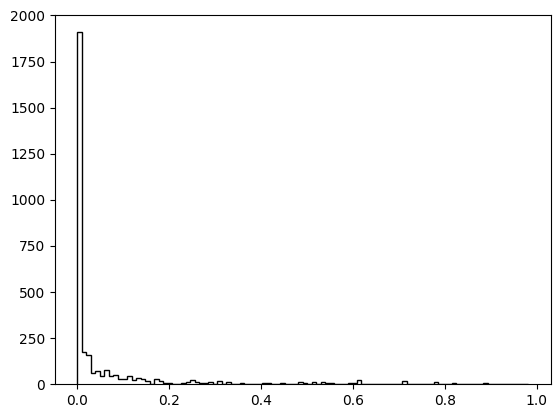

In [48]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")

(array([43.,  3., 23., 16.,  8., 22.,  4., 44., 16., 31., 17., 21., 34.,
        11., 30., 22., 22., 48.,  4., 15., 20., 10.,  8., 32., 20., 26.,
        17., 14., 11., 16., 18., 15., 19., 33., 36., 11., 32., 67., 57.,
        79., 54., 26., 54., 66., 50., 72., 46., 77., 47., 51., 42., 49.,
        42., 41., 63., 70., 61., 16., 44., 67., 49., 34., 50., 70., 36.,
        72., 48., 60., 33., 58., 69., 50., 40., 69., 69., 55., 24., 39.,
        42., 10., 31., 28.,  7., 20., 14., 27., 15.,  9.,  7.,  4., 23.,
         5.,  3.,  0.,  6.,  3.,  1.,  0.,  0.,  7.]),
 array([  0.48225991,   3.99582095,   7.50938198,  11.02294302,
         14.53650405,  18.05006509,  21.56362613,  25.07718716,
         28.5907482 ,  32.10430923,  35.61787027,  39.1314313 ,
         42.64499234,  46.15855337,  49.67211441,  53.18567545,
         56.69923648,  60.21279752,  63.72635855,  67.23991959,
         70.75348062,  74.26704166,  77.78060269,  81.29416373,
         84.80772477,  88.3212858 ,  91.83484684, 

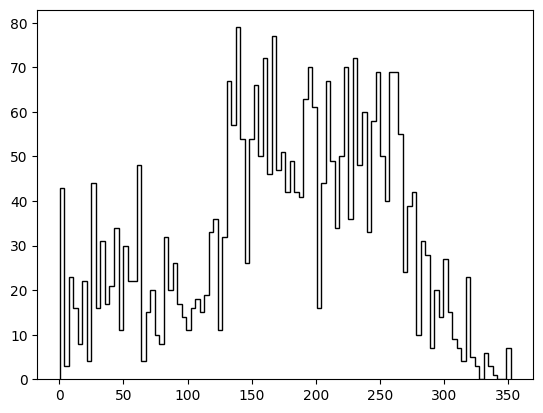

In [49]:
plt.hist(samples[:, 1], 100, color="k", histtype="step")

In [50]:
sampler.reset()
sampler.run_mcmc(state, 10000)

State([[5.48542980e-04 2.56967080e+02 5.79290343e+01]
 [5.01231222e-04 2.57176206e+02 6.31112624e+01]
 [5.07598469e-04 2.65573623e+02 4.33773304e+01]
 [5.23548321e-04 2.56560263e+02 4.71543815e+01]
 [5.27418677e-04 2.59841021e+02 5.04869105e+01]
 [4.86160938e-04 2.48777723e+02 5.43777214e+01]
 [4.70240338e-04 2.68354799e+02 4.27601168e+01]
 [5.41142789e-04 2.64942809e+02 5.34987057e+01]
 [5.53221926e-04 2.71499141e+02 4.32080568e+01]
 [4.80456996e-04 2.70477651e+02 6.26912781e+01]
 [5.11026375e-04 2.70050900e+02 4.05985091e+01]
 [4.85081305e-04 2.59605859e+02 3.95690123e+01]
 [5.00776891e-04 2.59413635e+02 4.81842205e+01]
 [4.51118093e-04 2.65093713e+02 4.11983358e+01]
 [5.38969742e-04 2.61342229e+02 4.18327090e+01]
 [4.95939284e-04 2.69030976e+02 5.72617524e+01]
 [4.19628701e-04 2.75302269e+02 4.55842337e+01]
 [4.75914083e-04 2.46009451e+02 6.19421925e+01]
 [5.06333854e-04 2.54702138e+02 5.32721242e+01]
 [4.80487688e-04 2.70789074e+02 5.46419035e+01]
 [5.31534743e-04 2.73947674e+02 4.

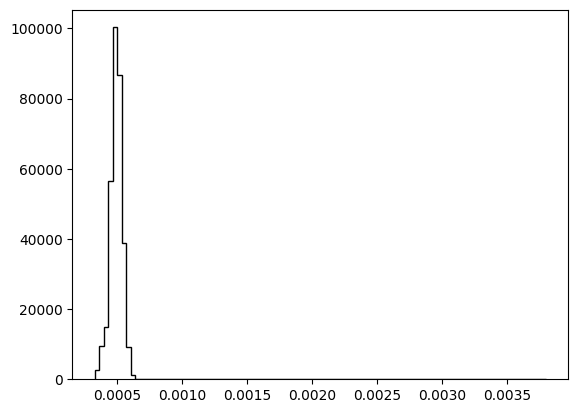

In [51]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.savefig('../plots/emcee_dip_g0p0005.png',dpi=600)

In [52]:
np.savetxt('emcee_sample_dip_g0p0005.txt',samples)

In [53]:
# samples = np.loadtxt('emcee_sample_dip_g0p005.txt')

In [54]:
samples[:,0]*=1e4

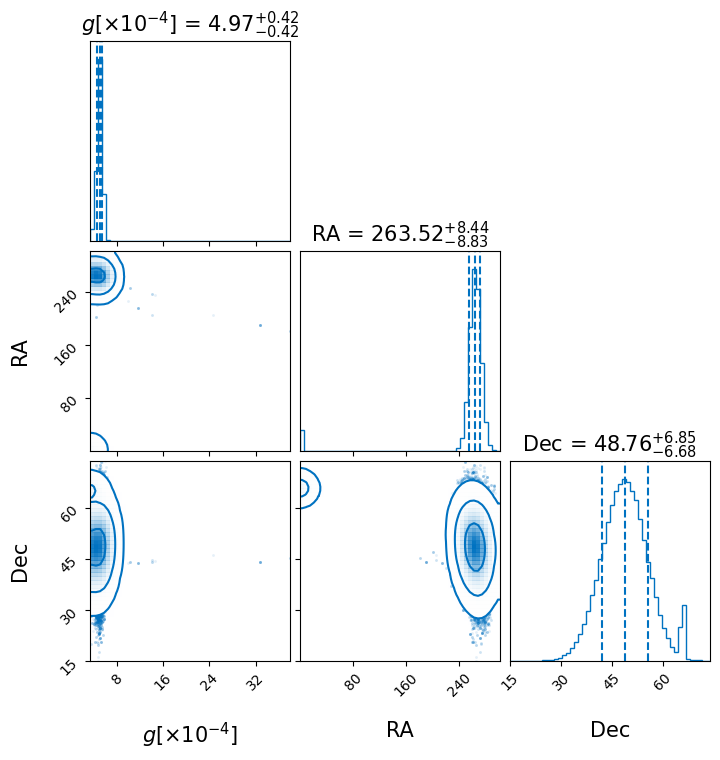

In [55]:
labels=[r'$g[\times 10^{-4}]$', 'RA', 'Dec']

fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p0005_corner.pdf',bbox_inches='tight')

In [40]:
# samples = np.loadtxt('emcee_sample_dip_g0p005.txt')

In [41]:
sample_hist = np.histogram(samples[:,0],bins=500)

In [42]:
from scipy.integrate import simps
cdi = confidence_interval(sample_hist[0]/simps(sample_hist[0],sample_hist[1][:-1]), sample_hist[1][:-1])

/tmp/ipykernel_355081/3624433521.py:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  cdi = confidence_interval(sample_hist[0]/simps(sample_hist[0],sample_hist[1][:-1]), sample_hist[1][:-1])
/tmp/ipykernel_355081/1718022243.py:38: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cdfvals = cumtrapz(self.posterior, self.param)


In [43]:
print(cdi.MAP(), cdi.upper_level-cdi.MAP(), cdi.MAP()-cdi.lower_level)

4.999866498994418 0.18890214417829654 0.19878826572157138


In [32]:
def logprob_dl_g_H0(H0glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, Om0=0.3):
    H0 = H0glb[0]
    g = H0glb[1]
    l = H0glb[2]
    b = H0glb[3]

    if 0<=g<1 and 0<=l<360 and -90<=b<=90 and 10<H0<200:

        dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
        dipole_ICRS = dipole_gal.transform_to('icrs')

        phi_dipole = dipole_ICRS.ra.value*np.pi/180
        theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

        nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
        ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
        nz_dipole = np.cos(theta_dipole)

        chi2 = 0

        for i in range(len(ra_arr)):
            phi = ra_arr[i]
            theta = np.pi/2-np.array(dec_arr[i])

            nx = np.cos(phi)*np.sin(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(theta)

            dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

            astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
            # zt = (1+zs_arr[i])/(1+dipole) -1
            dl_0 = astropy_cosmology.luminosity_distance(zs_arr[i]).value
            r = astropy_cosmology.comoving_distance(zs_arr[i]).value
            dl_g = dl_0*(1-dipole*(1+zs_arr[i])*C_SI*1e-3/r/astropy_cosmology.H(zs_arr[i]).value)

            chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2
        
        logprob = -0.5*chi2

    else:
        logprob = -np.inf

    return logprob

In [33]:
nwalkers = 32
ndim = 4
p0 = np.random.rand(nwalkers, ndim)*np.array([190,1,360,180]) - np.array([-10,0,0,90])
print(p0)

[[ 5.82314459e+01  6.71014072e-01  1.81602140e+02 -3.39780952e+00]
 [ 9.05697912e+01  2.28185358e-01  3.10566408e+02 -8.35836613e+01]
 [ 1.28543907e+02  8.59306683e-01  3.12017423e+02  6.95909378e+01]
 [ 8.60968584e+01  9.32913194e-01  2.96906534e+02  1.05499751e+00]
 [ 4.09740005e+01  3.41205698e-01  1.06932729e+02  5.28508203e+01]
 [ 4.32297079e+01  4.78032856e-01  1.03360248e+02 -6.91245896e+01]
 [ 1.60402438e+02  9.31770112e-01  1.45486863e+02  2.09117183e+01]
 [ 1.22685896e+02  9.26596563e-01  9.56732161e+00  5.73861579e+01]
 [ 1.16515451e+02  7.54400096e-02  2.93406329e+02 -4.29286060e+01]
 [ 1.19157319e+02  8.34827783e-01  9.59235009e+01 -1.66419886e+01]
 [ 1.95023678e+02  8.52179938e-01  1.37337936e+02 -1.54401204e+00]
 [ 2.43104222e+01  3.41367012e-01  6.93083604e+01  3.09783324e+01]
 [ 3.90344870e+01  2.61446652e-02  1.58133234e+01 -7.77706089e+00]
 [ 1.65336045e+02  9.91626548e-01  3.44949895e+02  6.01448932e+01]
 [ 1.64711472e+02  4.83836560e-01  1.20465629e+02  1.28770753e

In [34]:
logprob_dl_g_H0(p0[0], ra_mean, dec_mean, zs, dl_mean, dl_std)

-161657013.9135313

In [35]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_dl_g_H0, args=[ra_mean, dec_mean, zs, dl_mean, dl_std])


In [36]:
state = sampler.run_mcmc(p0, 100)


(array([  2.,   0.,   0.,  10.,   4.,   0.,   0.,   0.,   0.,   4.,   8.,
          0.,   1.,   0.,   5.,   1.,   1.,   2.,  14.,   1.,   1.,   0.,
          0.,   9.,   9.,   3.,  19.,  25.,  24.,  28., 258., 302., 179.,
        135.,  58., 112.,  72.,  69.,  42.,  56.,  71.,  58.,  65., 132.,
         79.,  75.,  71.,  69.,  85.,  57.,  55.,  92.,  48.,  50.,  74.,
         31.,  27.,  23.,  24.,  26.,  28.,  17.,  19.,  10.,   9.,  17.,
          9.,  25.,  10.,  11.,  25.,  12.,  26.,  13.,   7.,  15.,   1.,
          5.,  22.,  16.,  22.,  13.,  20.,  14.,  21.,   2.,  33.,  10.,
         15.,   3.,   0.,  34.,   0.,   5.,   4.,   7.,   7.,  10.,   6.,
         11.]),
 array([ 12.62963662,  14.47642776,  16.32321889,  18.17001002,
         20.01680115,  21.86359229,  23.71038342,  25.55717455,
         27.40396569,  29.25075682,  31.09754795,  32.94433908,
         34.79113022,  36.63792135,  38.48471248,  40.33150361,
         42.17829475,  44.02508588,  45.87187701,  47.71866814

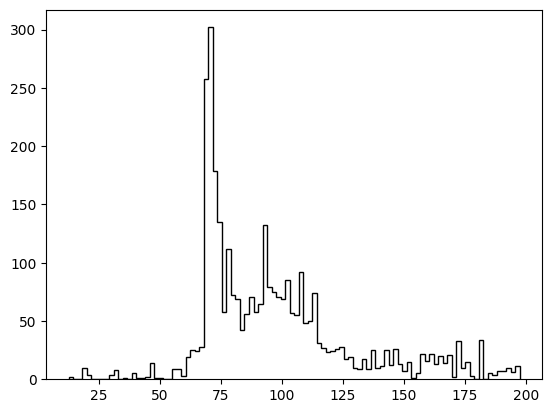

In [37]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")

In [38]:
sampler.reset()
sampler.run_mcmc(state, 10000)

State([[ 7.00061653e+01  1.26935877e-05  3.14723316e+01 -3.81720231e+01]
 [ 6.99573270e+01  3.75436360e-06  2.08145129e+02  8.48555524e+01]
 [ 6.99947075e+01  6.24357842e-05  2.69290316e+02 -7.38841062e+01]
 [ 6.99437300e+01  1.33795263e-06  2.03738009e+02 -5.16709562e+01]
 [ 6.99831669e+01  1.43144395e-05  3.22257450e+02 -1.09733660e+01]
 [ 6.99445087e+01  1.41231890e-04  1.76998256e+02  5.79760978e+01]
 [ 6.99915424e+01  9.69192317e-05  1.33388272e+02 -6.70708205e+01]
 [ 6.99163866e+01  8.48528913e-05  1.99240102e+02  7.03117396e+00]
 [ 6.99557909e+01  9.90095247e-06  5.22406796e+01  4.47873246e+01]
 [ 6.99206512e+01  1.67616084e-04  3.45702427e+02 -3.16355186e+01]
 [ 7.00323069e+01  3.79212925e-05  2.24407590e+02  5.83756406e+01]
 [ 7.00138312e+01  8.57478872e-05  1.73814154e+02  5.25643842e+01]
 [ 6.99941563e+01  4.22246361e-05  1.18901994e+02  1.22603531e+01]
 [ 7.00525303e+01  1.09349110e-04  1.39696246e+02 -3.99298179e+01]
 [ 6.99528773e+01  4.15037987e-05  5.86472411e+01  8.494

Text(0, 0.5, 'Count')

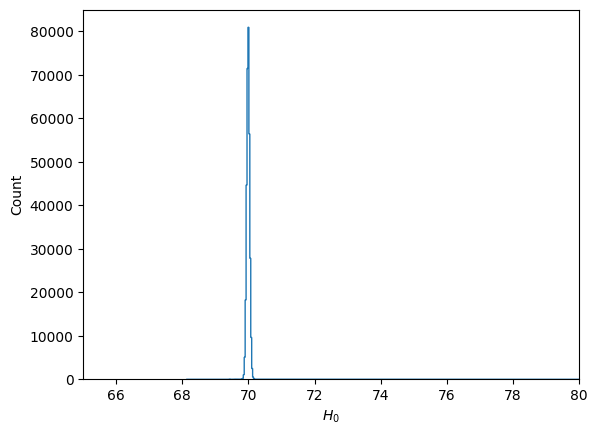

In [39]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 1000, histtype="step")
plt.xlim(65,80)
plt.xlabel(r'$H_0$')
plt.ylabel('Count')

In [40]:
np.savetxt('emcee_sample_dip_g0p0005_H0.txt',samples)

In [41]:
samples[:,1]*=1e4

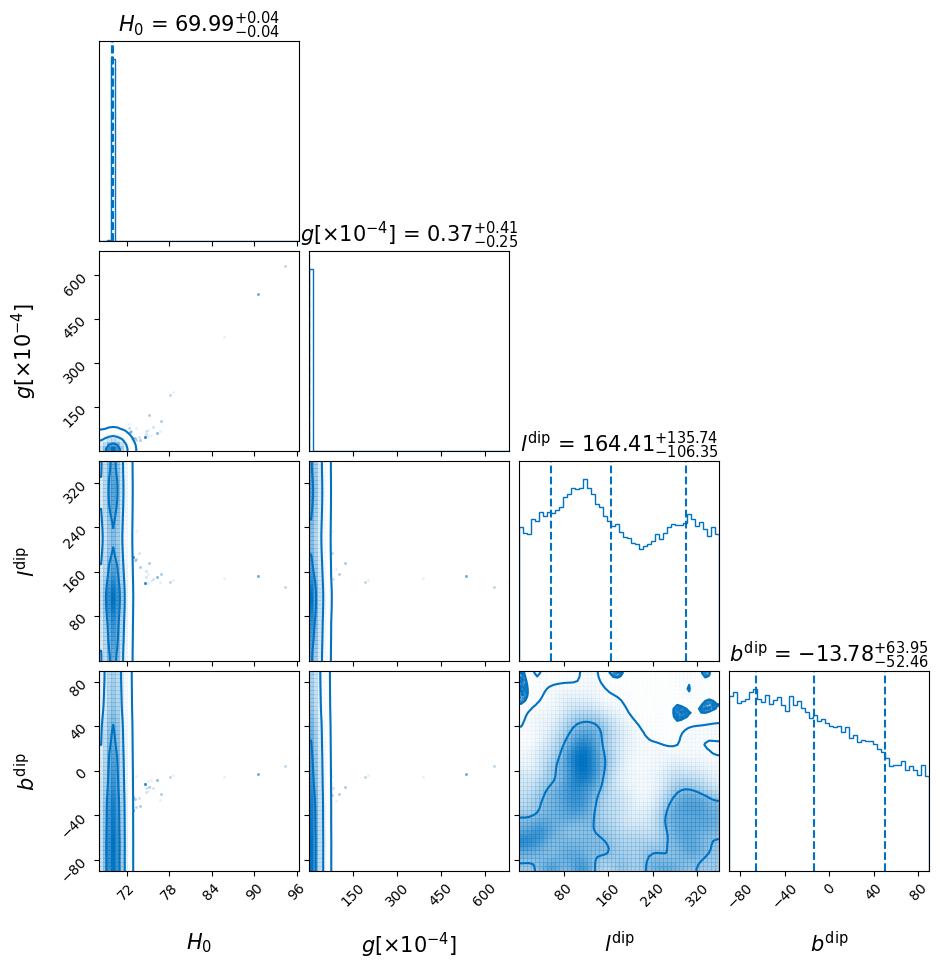

In [42]:
labels=[r'$H_0$',r'$g[\times 10^{-4}]$', r'$l^{\rm dip}$', r'$b^{\rm dip}$']

fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p0005_H0_corner.pdf',bbox_inches='tight')